# Motivation

When chunking documents for RAG, choosing the right chunk size is an exercise in managing tradeoffs. Large chunks provide better context to the LLM than small chunks, but they also make it harder to precisely retrieve specific pieces of information. Some queries (like simple factoid questions) are best handled by small chunks, while other queries (like higher-level questions) require very large chunks. There are some queries that can be answered with a single sentence from the document, while there are other queries that require entire sections or chapters to properly answer. Most real-world RAG use cases face a combination of these types of queries. 

What we really need is a more dynamic system that can retrieve short chunks when that's all that's needed, but can also retrieve very large chunks when required. How do we do that?

Our solution is motivated by one simple insight: relevant chunks tend to be clustered within their original documents. 

In [4]:
import sys
sys.path.append("../../dsRAG/")
import cohere
import os
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY') # OpenAI API key
os.environ["CO_API_KEY"] = os.getenv('CO_API_KEY') # Cohere API key

# Visualize chunk relevance distribution for single document
We'll use the Cohere Rerank API for rank our chunks. Normally, we'd start with a vector and/or keyword search to narrow down the list of candidates, but since we're just dealing with a single document here we can just send all chunks directly to the reranker, keeping things a bit simpler.

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_into_chunks(text: str, chunk_size: int):
    """
    Note: it's very important that chunk overlap is set to 0 here, since results are created by concatenating chunks.
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, length_function=len)
    texts = text_splitter.create_documents([text])
    chunks = [text.page_content for text in texts]
    return chunks

def transform(x):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1
    - The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)

def rerank_chunks(query: str, chunks: list) -> list:
    """
    Use Cohere Rerank API to rerank the search results
    """
    model = "rerank-english-v3.0"
    client = cohere.Client(api_key=os.environ["CO_API_KEY"])
    decay_rate = 30

    reranked_results = client.rerank(model=model, query=query, documents=chunks)
    results = reranked_results.results
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] # in order of reranked_indices
    
    # convert back to order of original documents and calculate the chunk values
    similarity_scores = [0] * len(chunks)
    chunk_values = [0] * len(chunks)
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i])
        similarity_scores[index] = absolute_relevance_value
        chunk_values[index] = np.exp(-i/decay_rate)*absolute_relevance_value # decay the relevance value based on the rank

    return similarity_scores, chunk_values

def plot_relevance_scores(chunk_values, start_index: int = None, end_index: int = None):
    plt.figure(figsize=(12, 5))
    plt.title(f"Similarity of each chunk in the document to the search query")
    plt.ylim(0, 1)
    plt.xlabel("Chunk index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(chunk_values)
    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])

In [12]:
file_path = "/Users/zach/Code/dsRAG/tests/data/nike_2023_annual_report.txt"

with open(file_path, 'r') as file:
    text = file.read()

chunks = split_into_chunks(text, chunk_size=800)

print (f"Split the document into {len(chunks)} chunks")

Split the document into 500 chunks


In [31]:
# Nike 10-K
#query = "Nike cash flow statement"
#query = "Nike revenue growth"
#query = "2023 Nike North America segment results"
#query = "Nike board of directors"
#query = "Nike supply chain challenges"
#query = "Nike CEO tenure"

# Example query that requires a short result
#query = "Nike CEO tenure"

# Example query that requires a longer result
query = "Nike consolidated financial statements"

similarity_scores, chunk_values = rerank_chunks(query, chunks)

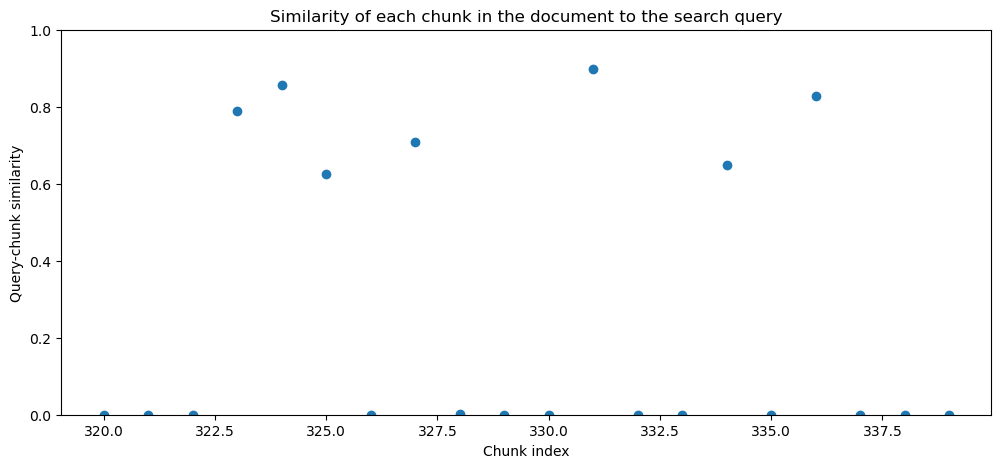

In [34]:
#plot_relevance_scores(chunk_values)
#plot_relevance_scores(chunk_values, 300, 350)
plot_relevance_scores(chunk_values, 320, 340)
#plot_relevance_scores(similarity_scores, 320, 340)

#### How to interpret the chunk relevance plot above
In the plot above, the x-axis represents the chunk index. The first chunk in the document has index 0, the next chunk has index 1, etc. The y-axis represents the relevance of each chunk to the query. Viewing it this way lets us see how relevant chunks tend to be clustered in one or more sections of a document. 

Note: the relevance values in this plot are actually a combination of the raw relevance value and the relevance ranks. An exponential decay function is applied to the ranks, and that is then multiplied by the raw relevance value. Using this combination provides a more robust measure of relevance than using just one or the other.

#### What can we do with these clusters of relevant chunks?
The core idea is that clusters of relevant chunks, in their original contiguous form, provide much better context to the LLM than individual chunks can. Now for the hard part: how do we actually identify these clusters?

If we can calculate chunk values in such a way that the value of a segment is just the sum of the values of its constituent chunks, then finding the optimal segment is a version of the maximum subarray problem, for which a solution can be found relatively easily. How do we define chunk values in such a way? We'll start with the idea that highly relevant chunks are good, and irrelevant chunks are bad. We already have a good measure of chunk relevance, on a scale of 0-1, so all we need to do is subtract a constant threshold value from it. This will turn the chunk value of irrelevant chunks to a negative number, while keeping the values of relevant chunks positive. We call this the `irrelevant_chunk_penalty`. A value around 0.2 seems to work well empirically.

In [19]:
def print_document_segment(chunks, start_index, end_index):
    for i in range(start_index, end_index):
        print(f"\nChunk {i}")
        print(chunks[i])

print_document_segment(chunks, 320, 340)


Chunk 320
financial statements, taken as a whole, and we are not, by communicating the critical audit matter below , providing a separate 
opinion on the critical audit matter or on the accounts or disclosures to which it relates.
Accounting for Income Taxes
As described in Notes 1 and 7 to the consolidated financial statements, the Company recorded income tax expense of $1,131 
million for the year ended May 31, 2023, and has net deferred tax assets of $1,799 million, including a valuation allowance of $22 
million, and total gross unrecognized tax benefits, excluding related interest and penalties, of $936 million as of May 31, 2023, 
$651 million of which would affect the Company's effective tax rate if recognized in future periods. The realization of deferred tax

Chunk 321
assets is dependent on future taxable earnings. Management assesses the scheduled reversal of deferred tax liabilities, 
projected future taxable income and available tax planning strategies and considers forei

In [37]:
def get_best_segments(relevance_values: list, max_length: int, overall_max_length: int, minimum_value: float):
    """
    This function takes the chunk relevance values and then runs an optimization algorithm to find the best segments.

    - relevance_values: a list of relevance values for each chunk of a document

    Returns
    - best_segments: a list of tuples (start, end) that represent the indices of the best segments (the end index is non-inclusive) in the document
    - scores: a list of the scores for each of the best segments

    Note: this is a simplified implementation intended for demonstration purposes. A more sophisticated implementation would be needed for production use and is available in the dsRAG library.
    """
    best_segments = []
    scores = []
    total_length = 0
    while total_length < overall_max_length:
        # find the best remaining segment
        best_segment = None
        best_value = -1000
        for start in range(len(relevance_values)):
            # skip over negative value starting points
            if relevance_values[start] < 0:
                continue
            for end in range(start+1, min(start+max_length+1, len(relevance_values)+1)):
                # skip over negative value ending points
                if relevance_values[end-1] < 0:
                    continue
                # check if this segment overlaps with any of the best segments and skip if it does
                if any(start < seg_end and end > seg_start for seg_start, seg_end in best_segments):
                    continue
                # check if this segment would push us over the overall max length and skip if it would
                if total_length + end - start > overall_max_length:
                    continue
                
                # define segment value as the sum of the relevance values of its chunks
                segment_value = sum(relevance_values[start:end])
                if segment_value > best_value:
                    best_value = segment_value
                    best_segment = (start, end)
        
        # if we didn't find a valid segment then we're done
        if best_segment is None or best_value < minimum_value:
            break

        # otherwise, add the segment to the list of best segments
        best_segments.append(best_segment)
        scores.append(best_value)
        total_length += best_segment[1] - best_segment[0]
    
    return best_segments, scores

In [38]:
irrelevant_chunk_penalty = 0.2
relevance_values = [v - irrelevant_chunk_penalty for v in chunk_values]
max_length = 20
overall_max_length = 30
minimum_value = 0.7

# get_best_segments solves a constrained version of the maximum sum subarray problem
best_segments, scores = get_best_segments(relevance_values, max_length, overall_max_length, minimum_value)

print (best_segments)
print (scores)
print ()

# print the best segments
for segment_start, segment_end in best_segments:
    # concatenate the text of the chunks in the segment
    segment_text = ""
    for i in range(segment_start, segment_end):
        segment_text += chunks[i] + "\n"

    print (segment_text)
    print ("\n---\n")

[(323, 337), (226, 231), (448, 453), (312, 313)]
[2.5559905778741827, 1.6569259433941705, 0.7325434206345869, 0.7318070628222588]

income taxes, evaluating changes in and compliance with tax laws, and testing the calculation of the provision of income taxes. 
Professionals with specialized skill and knowledge were used to assist in evaluating changes in and compliance with the tax laws 
and regulations and the provision for income taxes.
/s/ PricewaterhouseCoopers LLP
Portland, Oregon
July 20, 2023 
We have served as the Company's auditor since 1974. 
NIKE, INC.      54NIKE, INC.
CONSOLIDATED STATEMENTS OF INCOME
YEAR ENDED MAY 31,
(In millions, except per share data) 2023 2022 2021
Revenues $ 51,217 $ 46,710 $ 44,538 
Cost of sales  28,925  25,231  24,576 
Gross profit  22,292  21,479  19,962 
Demand creation expense  4,060  3,850  3,114 
Operating overhead expense  12,317  10,954  9,911
Total selling and administrative expense  16,377  14,804  13,025 
Interest expense (income), net  